# [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/overview)

Goal: create a model to identify metastatic cancer in small image patches

[Benchmark](https://github.com/basveeling/pcam#benchmark): 89.8

## Data features:
- No duplicates
- 96 x 96px images
- Can use horizontal/vertical flips
- Normalize by dividing by 255.0


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import pandas as pd
from fastai import *
from fastai.vision import *

In [3]:
path = Path('data')
path.ls()

[PosixPath('data/submission.csv'),
 PosixPath('data/test'),
 PosixPath('data/histopathologic-cancer-detection.zip'),
 PosixPath('data/train_labels.csv'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/train'),
 PosixPath('data/models')]

## First, grab the data and put it into a FastAI [ImageDataBunch](https://docs.fast.ai/vision.data.html#ImageDataBunch)

We intentionally set the image size to 64 so that we can increase the size later. This is a trick to train more and prevent overfitting!

In [13]:
arch = models.resnet34
df = pd.read_csv(path/'train_labels.csv')

def gen_data_bunch(img_size, crop_size=None, bs=1024):
    crop_size = 45
    train_tfms, valid_tfms = get_transforms(flip_vert=True)
    # Images are labeled based on whether a tumor appears
    # in the center 32x32 of the image
    if crop_size:
        train_tfms = [crop(size=crop_size)] + train_tfms

    data_bunch = (ImageDataBunch
                  .from_csv(path=path, 
                            folder='train', 
                            csv_labels='train_labels.csv',
                            valid_pct=0.25,
                            fn_col='id',
                            label_col='label',
                            suffix='.tif',
                            test='test',
                            ds_tfms=[train_tfms, valid_tfms],
                            size=img_size,
                            bs=bs))
    data_bunch.show_batch(rows=3, figsize=(8,8))
    return data_bunch

ImageDataBunch;

Train: LabelList (165019 items)
x: ImageList
Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45)
y: CategoryList
0,0,0,0,0
Path: data;

Valid: LabelList (55006 items)
x: ImageList
Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45)
y: CategoryList
0,1,1,0,0
Path: data;

Test: LabelList (57458 items)
x: ImageList
Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45)
y: EmptyLabelList
,,,,
Path: data

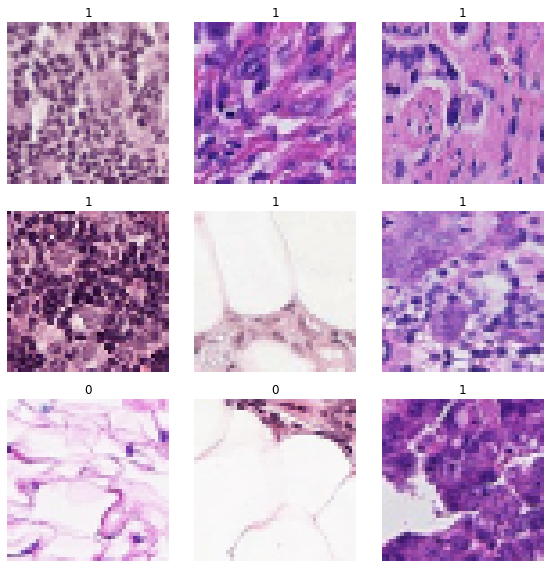

In [14]:
data = gen_data_bunch(img_size=45,crop_size=60)
data

## Train a Resnet

In [15]:
learn = cnn_learner(data, arch,
                    metrics=[accuracy],
                    path=path)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


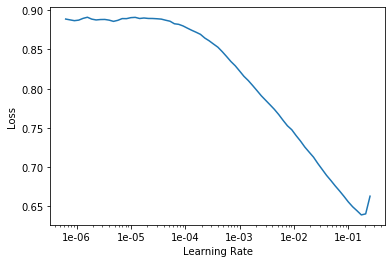

In [16]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.389853,0.317690,0.862942,01:30
1,0.296781,0.276331,0.890939,01:27
2,0.275317,0.281092,0.884213,01:27
3,0.261286,0.258907,0.893048,01:27
4,0.252037,0.260600,0.890957,01:27
5,0.243657,0.247508,0.900774,01:27
6,0.235370,0.227030,0.909264,01:27
7,0.225094,0.203623,0.918354,01:27
8,0.219828,0.200773,0.919754,01:27
9,0.217294,0.199203,0.919936,01:27


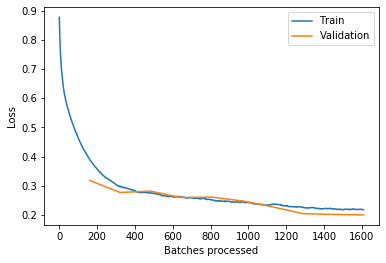

In [17]:
learn.fit_one_cycle(10, 1e-2)
learn.recorder.plot_losses()

In [18]:
learn.save('resnet50-stage-1')

## Interpretation - making sure we're heading in the right direction

In [19]:
from sklearn.metrics import roc_curve, auc

In [21]:
def plot_roc(learn):
    # log preds
    preds,y,loss = learn.get_preds(with_loss=True)
    acc = accuracy(preds, y)
    print('The accuracy is {0} %.'.format(acc))

    # probs from log preds
    probs = np.exp(preds[:,1])
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

    # Compute ROC area
    roc_auc = auc(fpr, tpr)
    print('ROC area is {0}'.format(roc_auc))

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
def interp_learner(learn):
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix(title='Confusion matrix')
    plot_roc(learn)

The accuracy is 0.9199360013008118 %.
ROC area is 0.9740489223276558


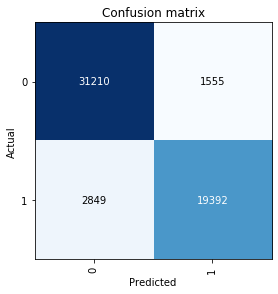

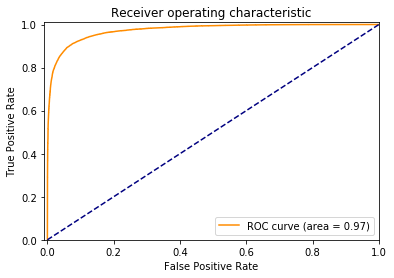

In [22]:
interp_learner(learn)

## Unfreeze all layers and train some more

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


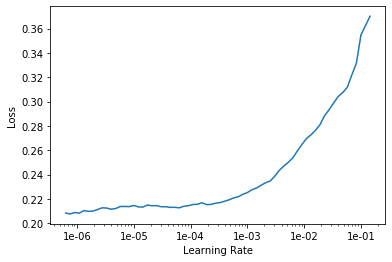

In [23]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.load('resnet50-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (165019 items)
x: ImageList
Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45)
y: CategoryList
0,0,0,1,1
Path: data;

Valid: LabelList (55006 items)
x: ImageList
Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45)
y: CategoryList
0,0,1,0,1
Path: data;

Test: LabelList (57458 items)
x: ImageList
Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45),Image (3, 45, 45)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1)

epoch,train_loss,valid_loss,accuracy,time
0,0.217148,0.198986,0.920191,01:36
1,0.215704,0.199331,0.919972,01:40
2,0.214999,0.199236,0.919827,01:30


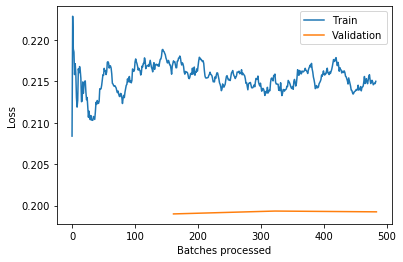

In [24]:
learn.fit_one_cycle(3, slice(1e-5))
learn.recorder.plot_losses()

In [25]:
learn.save('resnet50-stage-2')

## Interpretation again

The accuracy is 0.9198269248008728 %.
ROC area is 0.9741629562147103


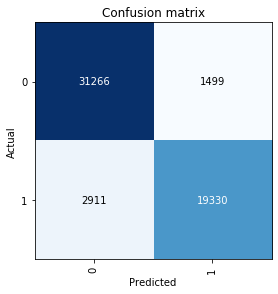

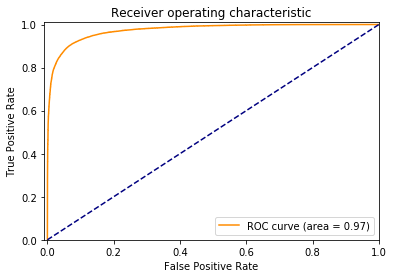

In [26]:
interp_learner(learn)

## Increase image sizes and train more

Learner(data=ImageDataBunch;

Train: LabelList (165019 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,1
Path: data;

Valid: LabelList (55006 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,1,0,0
Path: data;

Test: LabelList (57458 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

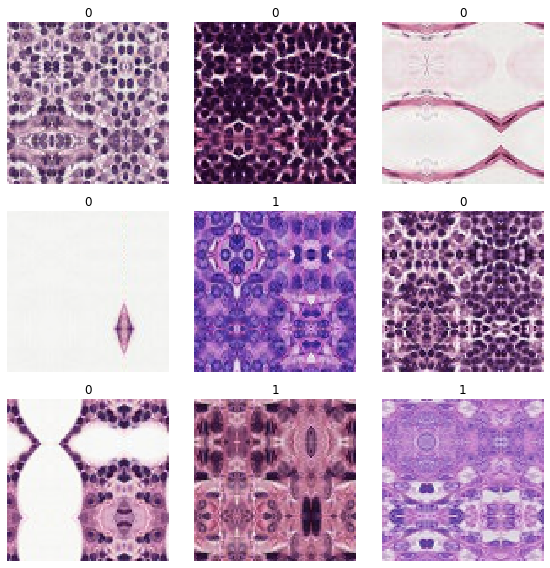

In [27]:
data = gen_data_bunch(img_size=96)
learn = cnn_learner(data, arch,
                    metrics=accuracy,
                    path=path)
learn.load('resnet50-stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


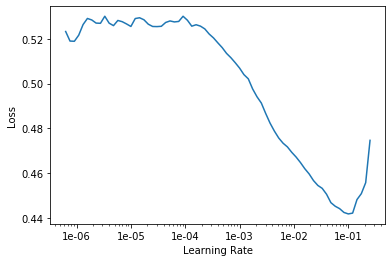

In [28]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.349747,0.306105,0.867596,01:40
1,0.307160,0.280105,0.881722,01:34
2,0.289303,0.267968,0.887158,01:35
3,0.281731,0.271079,0.884340,01:35
4,0.281021,0.265003,0.887412,01:35


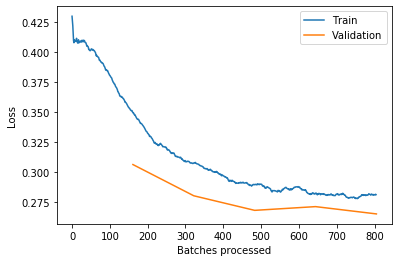

In [54]:
learn.fit_one_cycle(5, slice(1e-3,1e-2))
learn.recorder.plot_losses()

In [55]:
learn.save('resnet50-stage-3')

The accuracy is 0.8874123096466064 %.
ROC area is 0.95656671166665


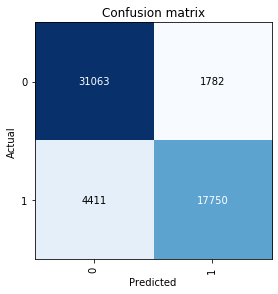

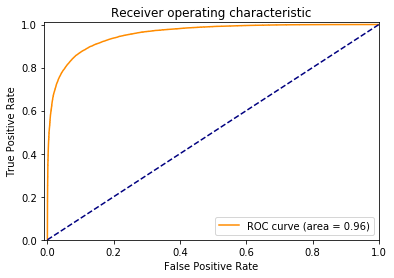

In [56]:
interp_learner(learn)

## Unfreeze and continue training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


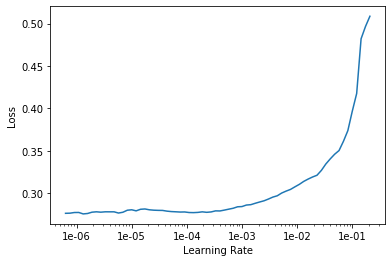

In [57]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.278164,0.263131,0.889448,01:40
1,0.270908,0.255574,0.893230,01:37
2,0.263212,0.247152,0.895939,01:28
3,0.258542,0.244753,0.898011,01:27
4,0.255788,0.243834,0.898229,01:27


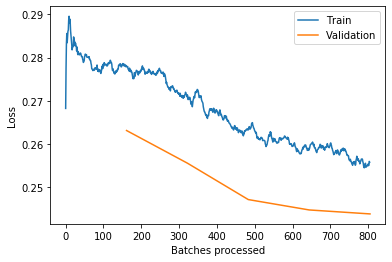

In [58]:
learn.fit_one_cycle(5, slice(1e-5,1e-4))
learn.recorder.plot_losses()

In [59]:
learn.save('resnet50-stage-4')

The accuracy is 0.8982293009757996 %.
ROC area is 0.9633902991262774


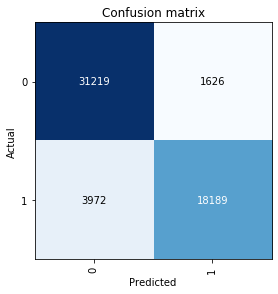

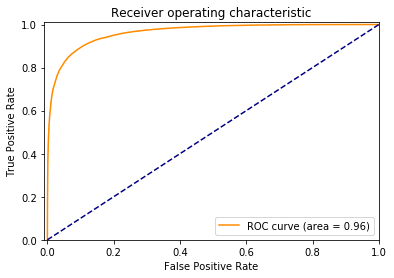

In [60]:
interp_learner(learn)

## Make predictions

In [81]:
num_preds = 1
preds = np.zeros(len(data.test_ds))
for i in range(num_preds):
    curr_preds = learn.get_preds(ds_type=DatasetType.Test)
    for i,p in enumerate(preds):
        preds[i] += curr_preds[1][i]
preds /= num_preds
preds = preds.astype('int')

In [82]:
ids = [f.stem for f in data.test_ds.items]

In [83]:
submission = pd.DataFrame({'id': ids, 'label': preds})
submission.head()

,id,label
0,c150ad69225e73ad3f7390d69bea276936bccebf,0
1,8525557122e985a73cc30c01ca2f2d46dcc69583,0
2,e4b8452860617b34031193acfc835a9269aa1258,0
3,e1e30dea5266dac0193224b64f1abaaa42204338,0
4,bb3130530249e53500b33c35422c57b9cff2d87e,0


In [84]:
submission.to_csv('data/submission.csv')

In [85]:
submission['label'].unique()

array([0])